In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
import tcripser
import gudhi,gudhi.hera,gudhi.wasserstein,persim
import ase
from ase.io import cube
from ase.io import cif
import multiprocessing
from multiprocessing.dummy import Pool
import pickle
import json

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import torch
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
import collections
import itertools

In [5]:
print(torch.__version__)

1.13.0+cu117


In [4]:

class RegressionCNN:
    def __init__(self, input_shape, output_size):
        self.input_shape = input_shape
        self.output_size = output_size
        self.model = self.build_model()

    def build_model(self):
        model = keras.Sequential()

        # add convolutional layers
        model.add(keras.layers.Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=self.input_shape))
        model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
        model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
        model.add(keras.layers.Dropout(0.1)) # maybe instead of a dropout we would prefer a gaussian hopping

        # add dense layers
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.2)) # this may help with vibrational degrees of freedom
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(self.output_size, activation='relu'))

        # compile the model
        model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())
        return model

    def train(self, x_train, y_train, batch_size, epochs):
        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

    def predict(self, x):
        return self.model.predict(x)


In [5]:
inDir="Z:/data/diverse_metals"
#inDir="/mnt/z/data/diverse_metals"
topTypes=os.listdir(inDir+"/diverseTop")

topTypes

['tFunc', 'tThresh-05', 'tThresh0']

In [63]:
topTypes=['tFunc', 'tThresh-05', 'tThresh0']

In [4]:
fName="DB7-ddmof_15992_PH" #


## Let's plot some PH
- find relatively good bounds to discretize

In [8]:
diags=np.load(f"{inDir}/{topTypes[0]}/{fName}.npy",allow_pickle=True)

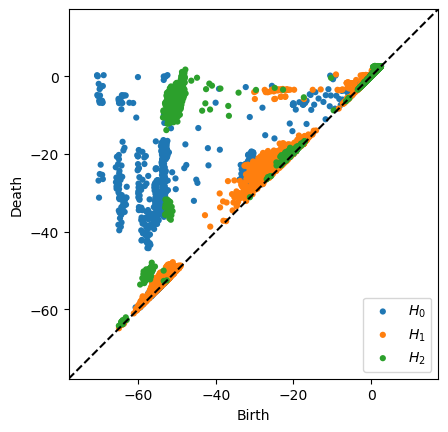

In [10]:
persim.plot_diagrams(list(diags))

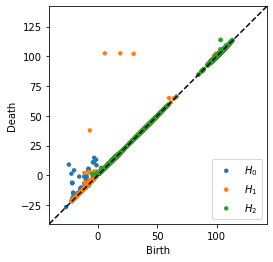

In [7]:
fName="DB7-ddmof_15992_PH"
diags2=np.load(f"{inDir}/{topTypes[1]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

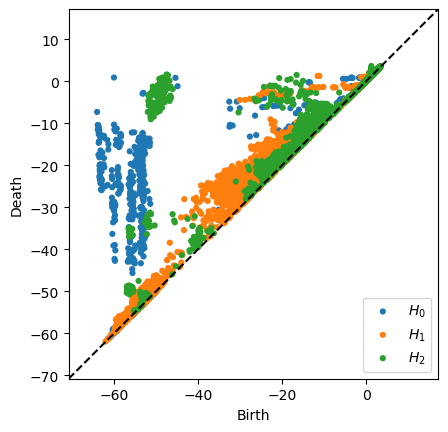

In [12]:
fName="DB1-Cu2O8-pcn6_B-TDPAT_No456_PH"
diags2=np.load(f"{inDir}/{topTypes[0]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

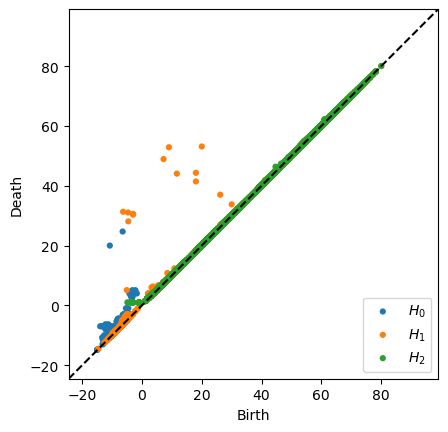

In [8]:
fName="DB1-Cu2O8-pcn6_B-TDPAT_No456_PH"
diags2=np.load(f"{inDir}/{topTypes[1]}/{fName}.npy",allow_pickle=True)
persim.plot_diagrams(list(diags2))

# Let's grab some outliars in the data and see if they have any apparent patterns

In [6]:
df=pd.read_csv(f"{inDir}/post-combustion-vsa-2-clean.csv",index_col=0)

In [7]:
df.head()

,mmol/g_working_capacity,selectivity
filename,,
DB0-m3_o12_o22_f0_pcu.sym.90,0.370563,13.582315
DB0-m3_o16_o460_f0_fsc.sym.19,2.774926,196.043735
DB0-m3_o8_o23_f0_pcu.sym.155,0.531669,8.000730
DB5-hypotheticalMOF_5044966_0_0_1_3_24_6,1.703426,67.395940
DB0-m3_o155_o151_f0_fsc.sym.13,0.937707,26.451195


Text(0.5, 0, 'mmol/g_working_capacity')

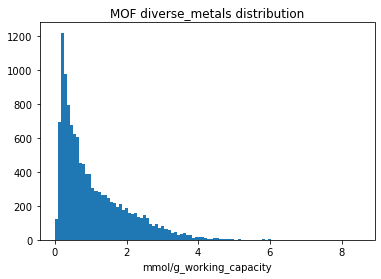

In [8]:
plt.hist(df["mmol/g_working_capacity"],bins=100) #>3.5 - 4
plt.title("MOF diverse_metals distribution")
plt.xlabel("mmol/g_working_capacity")

Text(0.5, 0, 'selectivity')

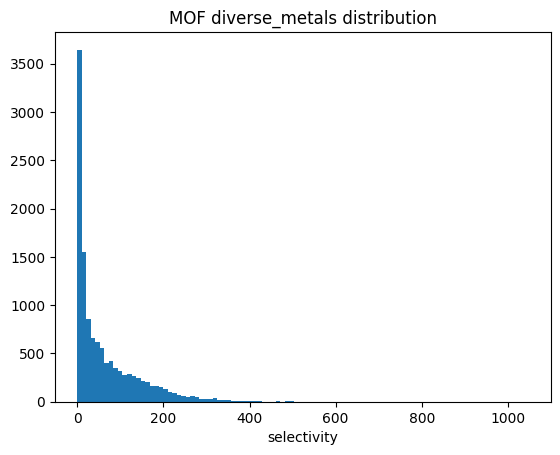

In [15]:
plt.hist(df["selectivity"],bins=100) #>300
plt.title("MOF diverse_metals distribution")
plt.xlabel("selectivity")

In [24]:
# grab 4 bins for each, trP% of samples within regions
##
## workingCap: [0-1,1-2,2-4,4-]
## selectivity: [0-50,50-200,200-400,400-]
trP=.70
totalLen=len(df['selectivity'])
regVars=['selectivity','mmol/g_working_capacity']
bounds={"selectivity":[(0,50),(50,200),(200,400),(400,)],"mmol/g_working_capacity":[(0,1),(1,2),(2,4),(4,)]}

indexBounds={k:[] for k in bounds.keys()} #upper index for 

for k in regVars:
    j=0
    bj=0
    for index,row in df.sort_values(by=[k]).iterrows():
        if bj>=3:
            break
        elif row[k]>bounds[k][bj][1]:
            indexBounds[k].append(j)
            bj+=1
        j+=1

In [19]:
indexBounds

{'selectivity': [7197, 11351, 12150],
 'mmol/g_working_capacity': [7305, 10156, 12064]}

12201

In [25]:
#seed, then random indices up to 

np.random.seed(42)
testBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[:indexBounds[k][j]],size=round((1-trP)*indexBounds[k][j]),replace=False)))
    for j in range(1,len(indexBounds[k])):
        testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]],size=round((1-trP)*(indexBounds[k][j]-indexBounds[k][j-1])),replace=False)))
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][-1]:],size=round((1-trP)*(totalLen-indexBounds[k][-1])),replace=False)))

    
    
trainBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[:indexBounds[k][j]])-set(testBins[k][j])))
    for j in range(1,len(indexBounds[k])):
        trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]])-set(testBins[k][j])))
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][-1]:])-set(testBins[k][-1])))


#  testBins["selectivity"] -> list of sampled bins along selectivity bounds
#testBins['selectivity'][0] selects lowest selective MOFS sample <-> 4 bins, {k:{"low":[MOFIDs for low selectivity],"med"...,"high","superHigh"}

In [37]:
np.random.choice(df.sort_values(by=['selectivity']).index[:7197],size=round((1-trP)*totalLen),replace=False)

array(['DB0-m3_o12_o25_f0_pcu.sym.7', 'DB0-m3_o2_o19_f0_pcu.sym.7',
       'DB0-m3_o12_o22_f0_pcu.sym.25', ..., 'DB12-MAKGEN_clean',
       'DB0-m3_o11_o25_f0_pcu.sym.12', 'DB0-m2_o10_o20_f0_pcu.sym.7'],
      dtype=object)

In [26]:
len(testBins['selectivity'][3])

15

In [14]:
testBins['selectivity'][3][:1]

['DB12-SEHZUB_clean']

In [27]:
#make valbins by grabbing testN//2, just pop off first half bc it's already random


valBins={k:[testBins[k][j][:len(testBins[k][j])//2] for j in range(len(testBins[k]))] for k in bounds.keys()}

for k in testBins.keys():
    for j in range(len(testBins[k])):
        for i in range(len(testBins[k][j])//2):
            testBins[k][j].pop(0)


In [28]:
len(trainBins['selectivity'][3])

36

In [29]:
len(testBins['selectivity'][3]),len(valBins['selectivity'][3])

(8, 7)

In [39]:
#df.columns=["workcap","sel"]
df.columns
#df.columns[0]="workcap"
newcols=["workcap","sel"]
list(zip(df.columns,newcols))

[('mmol/g_working_capacity', 'workcap'), ('selectivity', 'sel')]

In [40]:
#save subDFs with appropriate tag (train_test_val)
newcols=["workcap","sel"]
colT={k:v for k,v in zip(df.columns,newcols)}

foldName="dataSplitML"

try:
    os.mkdir(f"{inDir}/{foldName}")
except:
    pass

try:
    for k,v in colT.items():
        os.mkdir(f"{inDir}/{foldName}/{v}")
except:
    pass

for k,v in colT.items():
    df.loc[list(itertools.chain.from_iterable(valBins[k]))].to_excel(f"{inDir}/{foldName}/{v}/valCombustionDiverseMOF.xlsx")
    df.loc[list(itertools.chain.from_iterable(testBins[k]))].to_excel(f"{inDir}/{foldName}/{v}/testCombustionDiverseMOF.xlsx")
    df.loc[list(itertools.chain.from_iterable(trainBins[k]))].to_excel(f"{inDir}/{foldName}/{v}/trainCombustionDiverseMOF.xlsx")

#df.loc[list(itertools.chain.from_iterable(valBins['selectivity']))]

In [62]:
bounds={"selectivity":300,"mmol/g_working_capacity":3.75}

In [12]:
highbounds={"selectivity":300,"mmol/g_working_capacity":3.75}

selectAll=pd.DataFrame((i for _,i in df.iterrows() if False not in {i[k]>highbounds[k] for k in highbounds.keys()}))

In [13]:
len(selectAll)

21

In [36]:
selectAll

,filename,mmol/g_working_capacity,selectivity
1033,DB12-NEYZAU_clean,4.727319,564.061035
1109,DB12-IQEKOG_clean,5.701334,327.561420
2027,DB12-CUZBUW_clean,3.842521,300.440480
2158,DB12-LOBHAM_clean,5.786555,309.539870
2808,DB12-SERWAP_freeONLY,4.967852,309.405780
2858,DB5-hypotheticalMOF_5081767_0_0_2_29_1_14,5.144488,311.509245
3315,DB5-hypotheticalMOF_22163_0_0_1_11_10_13,4.884263,324.403595
3461,DB12-NAWKII_clean,3.905228,304.836540
4983,DB5-hypotheticalMOF_5050675_0_0_1_23_3_12,3.792218,351.761515
5018,DB1-Zn2O8-fum_A-irmof20_A_No142,7.928258,336.277145


In [ ]:
#create pImages -> [b, d-b]

outDir=f"{inDir}/diverseTopPHimg"

try:
    os.mkdir(outDir)
except:
    pass

for tp in topTypes:
    try:
        os.mkdir(outDir+"/"+tp)
    


# Torch imp

In [6]:
import torch
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
from typing import *


In [7]:
inDir="Z:/data/diverse_metals"
phDF=pd.read_csv(f"{inDir}/phDF_tThresh0_B1.csv",index_col=0)
phDF.index

Index(['DB0-m15_o10_o139_f0_fsc', 'DB0-m15_o11_o139_f0_fsc',
       'DB0-m15_o12_o140_f0_fsc', 'DB0-m15_o13_o141_f0_fsc',
       'DB0-m15_o14_o146_f0_fsc', 'DB0-m15_o15_o44_f0_fsc',
       'DB0-m15_o15_o46_f0_fsc', 'DB0-m15_o16_o109_f0_fsc',
       'DB0-m15_o16_o144_f0_fsc', 'DB0-m15_o16_o79_f0_fsc',
       ...
       'DB7-ddmof_7110', 'DB7-ddmof_7167', 'DB7-ddmof_7177', 'DB7-ddmof_7179',
       'DB7-ddmof_722', 'DB7-ddmof_7235', 'DB7-ddmof_790', 'DB7-ddmof_936',
       'DB7-ddmof_96', 'DB7-ddmof_972'],
      dtype='object', length=12201)

In [8]:
newThresh=[-8,25]
pBounds=[-25,50]

truncCols=[i for i in phDF.columns[4:] if newThresh[0]<=int(i.split("_")[0])<=newThresh[1] and newThresh[0]<=int(i.split("_")[1])<=newThresh[1]]

phDFSub=phDF[list(phDF.columns[:4])+list(truncCols)]

In [9]:
phDFSub

,belowPersistent,abovePersistent,belowWeak,aboveWeak,-8_-8,-8_-7,-8_-6,-8_-5,-8_-4,-8_-3,...,22_22,22_23,22_24,22_25,23_23,23_24,23_25,24_24,24_25,25_25
DB0-m15_o10_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o11_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,16,0,0,0,10,0,0,0,0,0
DB0-m15_o12_o140_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,12,0,0,0,0,0
DB0-m15_o13_o141_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,2,0,0,4,0,4
DB0-m15_o14_o146_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_7235,0,0,0,0,334,0,0,0,0,0,...,200,0,0,0,141,0,0,108,0,75
DB7-ddmof_790,0,0,0,0,2,0,0,0,0,0,...,138,2,0,0,71,0,0,43,0,43
DB7-ddmof_936,0,0,0,0,5,1,0,0,0,0,...,327,2,0,0,241,0,0,190,2,226
DB7-ddmof_96,0,0,0,0,1,0,0,0,0,0,...,133,1,0,0,196,1,1,251,0,233


In [28]:
life=newThresh[1]-newThresh[0]
phImg=np.zeros((len(phDFSub.index),life+1,life+1))#,dtype='uint8')

m=0
for mof in phDFSub.index:
    for b in np.arange(newThresh[0],newThresh[1]+1):
        for d in np.arange(b,newThresh[1]+1):
            phImg[m,newThresh[1]-d,b-newThresh[0]]=phDFSub.loc[mof][f"{b}_{d}"]
    m+=1

In [29]:
np.save(f"{inDir}/phImg_-8_25.npy",phImg)

In [130]:
class CubePHDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: str, newThresh: List[int]=[-8, 25]):
        phDF: pd.DataFrame = pd.read_csv(f"{root_dir}/phDF_tThresh0_B1.csv",index_col=0)
        truncCols=[i for i in phDF.columns[4:] if newThresh[0]<=int(i.split("_")[0])<=newThresh[1] and newThresh[0]<=int(i.split("_")[1])<=newThresh[1]]
        phDFSub=phDF[list(phDF.columns[:4])+list(truncCols)]

        self.data: torch.Tensor = torch.from_numpy(phDFSub.values)
        self.names: List[str] = list(phDFSub.columns)
        self.cifs: List[str] = list(phDFSub.index)

        self.property=pd.read_csv(f"{root_dir}/post-combustion-vsa-2-clean.csv",index_col=0).loc[self.cifs]
        self.property.columns = ['workcap', 'sel']
        self.propCols=list(self.property.columns)

        #(num_MOF, heeight, width)
        #channels=1
        self.life=newThresh[1]-newThresh[0]
        """
        phImg=np.zeros((len(self.cifs),life+1,life+1))#,dtype='uint8')

        for m in range(len(self.cifs)):
            for b in np.arange(newThresh[0],newThresh[1]+1):
                for d in np.arange(b,newThresh[1]+1):
                    phImg[m,newThresh[1]-d,b-newThresh[0]]=phDFSub[f"{b}_{d}"].loc[self.cifs[m]]
        """
        self.phImg = torch.from_numpy(np.load(f"{inDir}/phImg_-8_25.npy")).type(torch.float32)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return {"pd": self.data[index], "image": self.phImg[index], "cif": self.cifs[index],
                "workcap": torch.from_numpy(self.property.iloc[index:index+1, 0].values).to(self.phImg).view(1,),
                "sel": torch.from_numpy(self.property.iloc[index:index+1, 1].values).to(self.phImg).view(1,),
                }

dataset = CubePHDataset(inDir)


In [129]:
display(dataset.property.iloc[10:11, 0].values)
dataset.cifs[:10]

array([1.312731])

['DB0-m15_o10_o139_f0_fsc',
 'DB0-m15_o11_o139_f0_fsc',
 'DB0-m15_o12_o140_f0_fsc',
 'DB0-m15_o13_o141_f0_fsc',
 'DB0-m15_o14_o146_f0_fsc',
 'DB0-m15_o15_o44_f0_fsc',
 'DB0-m15_o15_o46_f0_fsc',
 'DB0-m15_o16_o109_f0_fsc',
 'DB0-m15_o16_o144_f0_fsc',
 'DB0-m15_o16_o79_f0_fsc']

torch.FloatTensor
torch.Size([20, 34, 34])
torch.FloatTensor torch.LongTensor torch.LongTensor


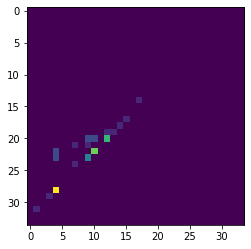

In [131]:
x = dataset[5000]['image']
x.size()
sqlen=len(x)
"""
for b in range(sqlen):
    x[sqlen-b-1,b]=0
"""
print(x.type())
xcopy = x.expand(20,-1,-1)
xcopy_ = xcopy.clone()
print(xcopy.size())
yrange = torch.arange(sqlen)
print(xcopy.type(), yrange.type(), yrange.__reversed__().type())
xcopy_[:, yrange.__reversed__(), yrange] = torch.tensor(0).to(xcopy_) #.type(torch.float64)

#x[yrange.__reversed__(), yrange] = torch.tensor(0)
plt.imshow(xcopy_[7])
#np.diag_indices(x.size(1))


In [135]:
def collate_fn(batch):
    #print(batch)
    #pd, image, cif = batch['pd'], batch['image'], batch['cif']
    elem = batch[0]
    assert isinstance(elem, collections.abc.Mapping)
    #print(type(batch))

    mapped_dict = {key: torch.stack([d[key] for d in batch], dim=0) for key in elem if key in ['pd', 'image', 'workcap', 'sel'] }
    mapped_dict.update({key: [d[key] for d in batch] for key in elem if key not in ['pd', 'image', 'workcap', 'sel']})
    #print(mapped_dict.keys())

    pd, image, cif, workcap, sel = mapped_dict['pd'], mapped_dict['image'], mapped_dict['cif'], mapped_dict['workcap'], mapped_dict['sel']

    sqlen=len(image[0])
    #image=torch.from_numpy(np.ndarray([[image[]]]))
    #for b in range(sqlen):
    #    image[sqlen-b-1,b]=0
    image_ = image.clone()
    yrange = torch.arange(sqlen)
    image_[:, yrange.__reversed__(), yrange] = torch.tensor(0).to(image_)
    return dict(pd=pd, image=image_[:,None,...], cif=cif, workcap=workcap, sel=sel)


In [166]:
print(len(dataset))
train, valid, test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

train_dataloader = torch.utils.data.DataLoader(train, batch_size=512, pin_memory=True, num_workers=0, shuffle=True, collate_fn=collate_fn)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=512, pin_memory=True, num_workers=0, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=512, pin_memory=True, num_workers=0, shuffle=False, collate_fn=collate_fn)

data = next(iter(train_dataloader))
data['sel'].size()

12201


torch.Size([512, 1])

In [140]:
class RegressionCNN(torch.nn.Module):
  def __init__(self, input_size=1, output_size=1, image_size=128, kernel_size=3):
    super().__init__()
    self.input_size = input_size #(input channel e.g. RBG)
    self.output_size = output_size #(num_classes)
    self.image_size = image_size #(height, width)
    self.kernel_size = kernel_size #(filter size)
    self.model = self.build_model()

  @property
  def computeRF(self, ):
    #(h = np.floor(H + 2p - d*(k-1) - 1) / s)
    return np.floor(self.image_size - (self.kernel_size - 1) - 1)

  def build_model(self):
    # add convolutional layers
    layers = [
        torch.nn.Conv2d(self.input_size, 32, kernel_size=self.kernel_size), #input: (1,128,128) -> output: (32, 125, 125)
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(32, 64, kernel_size=self.kernel_size), #input: (32, 125, 125) -> output: (64, 122, 122)
        torch.nn.ReLU(inplace=True),

        #torch.nn.MaxPool2d(kernel_size=(2,2)), #input: (64, 122, 122) -> output: (64, 61, 61)
        torch.nn.AdaptiveMaxPool2d(10), #input: (64, 122, 122)  -> output: (64, 10, 10)
        torch.nn.Dropout(0.25),

        # add dense layers
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(64*10*10, 128),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(0.25),
        torch.nn.Linear(128, self.output_size),
        ]
    #model = torch.nn.Sequential(*layers)
    model = torch.nn.ModuleList(layers)

    # compile the model
    return model

  def forward(self, pd=None, image=None, cif=None, workcap=None, sel=None):
    x = image
    for layer in self.model:
      x = layer(x)
    return x

model = RegressionCNN()
print(model.__class__.__name__)
#print(model.state_dict())

model(**data)

RegressionCNN


tensor([[ 0.2441],
        [-0.0264],
        [-0.0546],
        [ 0.0253],
        [-0.0226],
        [-0.0172],
        [-0.0943],
        [ 0.0306],
        [-0.0212],
        [ 0.1094],
        [ 0.0430],
        [-0.0173],
        [-0.0485],
        [ 0.0936],
        [-0.0690],
        [ 0.0425]], grad_fn=<AddmmBackward0>)

In [167]:
def main(args):
    epochs = 2
    loss_fn = torch.nn.MSELoss()
    device = torch.device(0) #torch.cuda.current_device()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters()) #model.parameters() # extract Ws from the model
    best_loss = np.inf

    for e in range(epochs):
      for batch in train_dataloader:
        model.train()
        optimizer.zero_grad(set_to_none=True) #dL/dWs = 0 vs None
        image = batch['image'].to(device)
        pred = model(image=image) #output (batch, 1)
        y = batch['workcap'].to(device) #output (batch, 1)
        loss = loss_fn(pred, y) #scalar (Tensor)
        loss.backward() #gradient dL/dWs
        optimizer.step() #W <- W - lr * dL/dWs
      val_loss = 0.
      for batch in valid_dataloader:
        model.eval()
        image = batch['image'].to(device)
        pred = model(image=image) #output (batch, 1)
        y = batch['workcap'].to(device) #output (batch, 1)
        loss = loss_fn(pred, y) #scalar (Tensor)
        val_loss += loss.item()
      val_loss /= len(valid_dataloader)
      if val_loss < best_loss:
        torch.save({"model":model.state_dict()}, f"{inDir}/seth_nn.pth")
        best_loss = val_loss
    print(f"At epoch {e} loss {val_loss} ")

args=None
main(args)

At epoch 1 loss 0.4763989945252736 


In [164]:
ckpt = torch.load(f"{inDir}/seth_nn.pth", map_location=device)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

# Naive Tree model

## The next step should be to build a 'higher-dimensional' DT algorithm. At each step, we want to find the region in H_k:[b,d] space that maximizes information with respect to the regressor

In [79]:
import sklearn.tree
from sklearn.tree import DecisionTreeRegressor

In [38]:
df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)
df.head()

,mmol/g_working_capacity,selectivity
filename,,
DB0-m3_o12_o22_f0_pcu.sym.90,0.370563,13.582315
DB0-m3_o16_o460_f0_fsc.sym.19,2.774926,196.043735
DB0-m3_o8_o23_f0_pcu.sym.155,0.531669,8.000730
DB5-hypotheticalMOF_5044966_0_0_1_3_24_6,1.703426,67.395940
DB0-m3_o155_o151_f0_fsc.sym.13,0.937707,26.451195


In [65]:
np.random.seed(42)
dlength=len(df["selectivity"])
labShuf=np.array(range(dlength))
np.random.shuffle(labShuf)

tr,te=.8,.2

trainMOFs=list(df.index[labShuf[:int(np.ceil(tr*dlength))]])
testMOFs=list(df.index[labShuf[int(np.ceil(tr*dlength)):]])

In [67]:
set(selectAll.index) & set(trainMOFs)

{'DB1-Cu2O8N2-irmof6_A_No10',
 'DB1-Zn2O8-fum_A-irmof20_A_No142',
 'DB1-Zn2O8N2-irmof8_A-TePM_No469',
 'DB12-HAFVUH_SL',
 'DB12-IQEKOG_clean',
 'DB12-LOBHAM_clean',
 'DB12-NAWKII_clean',
 'DB12-NEYZAU_clean',
 'DB12-NURMUJ_clean',
 'DB12-TOXNIF_clean',
 'DB12-XESKAJ_clean',
 'DB5-hypotheticalMOF_22163_0_0_1_11_10_13',
 'DB5-hypotheticalMOF_35842_0_0_2_14_1_2',
 'DB5-hypotheticalMOF_5050675_0_0_1_23_3_12',
 'DB5-hypotheticalMOF_5081767_0_0_2_29_1_14'}

In [60]:
df.index[[0,1]]

Index(['DB0-m3_o12_o22_f0_pcu.sym.90', 'DB0-m3_o16_o460_f0_fsc.sym.19'], dtype='object', name='filename')

In [6]:
newThresh=[-8,25]
pBounds=[-25,50]
life=pBounds[1]-pBounds[0]
#phDF.columns[4+(newThresh[0]-pBounds[0])*(newThresh[0]-pBounds[0]+1):]
truncCols=[i for i in phDF.columns[4:] if newThresh[0]<=int(i.split("_")[0])<newThresh[1] and newThresh[0]<=int(i.split("_")[1])<newThresh[1]]

phDFSub=phDF[list(phDF.columns[:4])+list(truncCols)]

In [7]:
phDFSub


,belowPersistent,abovePersistent,belowWeak,aboveWeak,-8_-8,-8_-7,-8_-6,-8_-5,-8_-4,-8_-3,...,21_21,21_22,21_23,21_24,22_22,22_23,22_24,23_23,23_24,24_24
DB0-m15_o10_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB0-m15_o11_o139_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,33,1,0,0,16,0,0,10,0,0
DB0-m15_o12_o140_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12,0,0
DB0-m15_o13_o141_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,8,0,0,2,0,4
DB0-m15_o14_o146_f0_fsc,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_7235,0,0,0,0,334,0,0,0,0,0,...,312,0,0,0,200,0,0,141,0,108
DB7-ddmof_790,0,0,0,0,2,0,0,0,0,0,...,277,0,0,0,138,2,0,71,0,43
DB7-ddmof_936,0,0,0,0,5,1,0,0,0,0,...,330,3,0,0,327,2,0,241,0,190
DB7-ddmof_96,0,0,0,0,1,0,0,0,0,0,...,157,0,0,0,133,1,0,196,1,251


In [77]:
regVar="mmol/g_working_capacity"#"mmol/g_working_capacity""selectivity"
trInd=trainBins[regVar][0]+trainBins[regVar][1]+trainBins[regVar][2]+trainBins[regVar][3]
phDF_train=phDFSub.loc[trInd]

teInd=testBins[regVar][0]+testBins[regVar][1]+testBins[regVar][2]+testBins[regVar][3]
phDF_test=phDFSub.loc[teInd]

In [123]:
reg=DecisionTreeRegressor(random_state=42)
reg.max_depth=14
ytr=[df.loc[ind][regVar] for ind in trInd]
reg.fit(phDF_train,ytr)

DecisionTreeRegressor(max_depth=14, random_state=42)

In [124]:
pred=reg.predict(phDF_test)
yte=[df.loc[ind][regVar] for ind in teInd]

for k in zip(pred,yte):
    print(k)
    

(0.5016137610350078, 0.771717)
(0.7882994705882354, 0.269496)
(0.32363661788617887, 0.128796)
(0.6422472173913045, 0.185432)
(1.6943580319148934, 0.646864)
(0.8916932222222222, 0.545297)
(0.5016137610350078, 0.386914)
(0.4823325454545454, 0.217427)
(0.6339191238938053, 0.385269)
(0.5016137610350078, 0.145361)
(0.7600592121212123, 0.317109)
(0.3410150499999999, 0.166841)
(0.20895946634615398, 0.181236)
(0.7334837283950616, 0.767768)
(0.5327583733031679, 0.502348)
(0.9347050144927534, 0.727122)
(0.493891, 0.009662)
(2.0089372155688627, 0.596112)
(0.6518123648648648, 0.371438)
(0.9347050144927534, 0.557503)
(0.40799322388059706, 0.915679)
(0.39142613333333354, 0.242702)
(0.39142613333333354, 0.598978)
(1.0892361834319533, 0.700279)
(0.647488796875, 0.332877)
(0.6142596142857143, 0.268446)
(0.20895946634615398, 0.252066)
(0.647488796875, 0.407185)
(1.0892361834319533, 0.774122)
(1.6923606, 0.514161)
(0.5016137610350078, 0.658801)
(0.957506, 0.253842)
(0.7600592121212123, 0.071084)
(0.32572

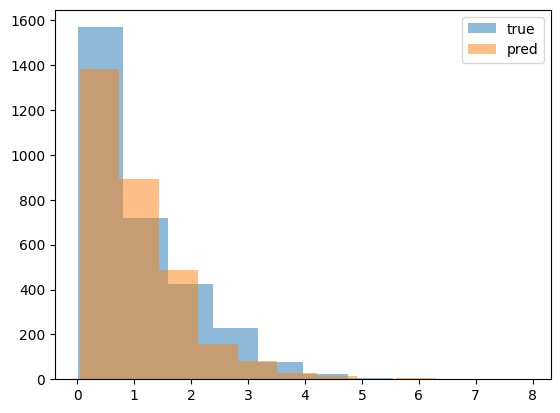

In [125]:
plt.hist(yte,alpha=.5,label="true")
plt.hist(pred,alpha=.5,label="pred")
plt.legend(loc='upper right')
plt.show()

(array([1.00e+00, 9.00e+00, 2.60e+01, 1.71e+02, 1.89e+03, 7.94e+02,
        1.39e+02, 1.10e+01, 7.00e+00, 2.00e+00]),
 array([-6.755415  , -5.36382241, -3.97222982, -2.58063724, -1.18904465,
         0.20254794,  1.59414053,  2.98573311,  4.3773257 ,  5.76891829,
         7.16051088]),
 <BarContainer object of 10 artists>)

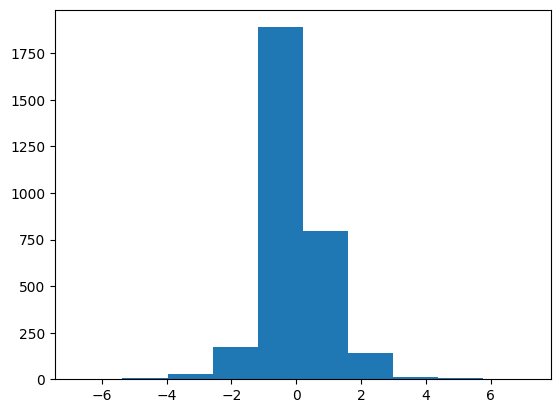

In [126]:
plt.hist([a-b for a,b in zip(yte,pred)])

In [127]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn import neural_network
from sklearn.neural_network import MLPRegressor

In [176]:
reg=MLPRegressor(hidden_layer_sizes=(3,),random_state=42,activation='logistic',learning_rate='adaptive')
reg.fit(phDF_train,ytr)

/home/smoore/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=(3,),
             learning_rate='adaptive', random_state=42)

In [177]:
pred=reg.predict(phDF_test)
yte=[df.loc[ind][regVar] for ind in teInd]



ss=0
for k in zip(pred,yte):
    print(k)
    ss+=(np.abs(k[0])-k[1])**2
sse['NN_3L_logistic_abs']=ss/len(yte)

(0.5851229109515974, 0.771717)
(2.2422993604182326, 0.269496)
(0.25376668575271655, 0.128796)
(1.0757590960565857, 0.185432)
(1.2710405139232033, 0.646864)
(2.240901511420432, 0.545297)
(0.2574551425798197, 0.386914)
(0.2537666857546008, 0.217427)
(0.6523123005807205, 0.385269)
(0.6845187825759496, 0.145361)
(2.24643853461226, 0.317109)
(0.7960443388750509, 0.166841)
(0.2539222988561751, 0.181236)
(0.6859553135027943, 0.767768)
(0.8199966322297754, 0.502348)
(1.0451002014797077, 0.727122)
(1.0436001990637243, 0.009662)
(2.246934717890121, 0.596112)
(0.38130021919430757, 0.371438)
(1.1083146705837421, 0.557503)
(1.3763859412264212, 0.915679)
(0.3209609797207267, 0.242702)
(0.4586576644227336, 0.598978)
(1.0616395466903528, 0.700279)
(0.19871011789285298, 0.332877)
(0.25378160753901713, 0.268446)
(0.25376668575271655, 0.252066)
(0.8386636570304509, 0.407185)
(0.4075282257197972, 0.774122)
(0.8913180562794398, 0.514161)
(0.26205223277299794, 0.658801)
(0.25376700071670877, 0.253842)
(1.04

(array([1.200e+02, 9.200e+02, 1.567e+03, 3.100e+02, 1.030e+02, 1.500e+01,
        1.000e+01, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([-2.07459617, -1.16932864, -0.2640611 ,  0.64120644,  1.54647397,
         2.45174151,  3.35700904,  4.26227658,  5.16754411,  6.07281165,
         6.97807918]),
 <BarContainer object of 10 artists>)

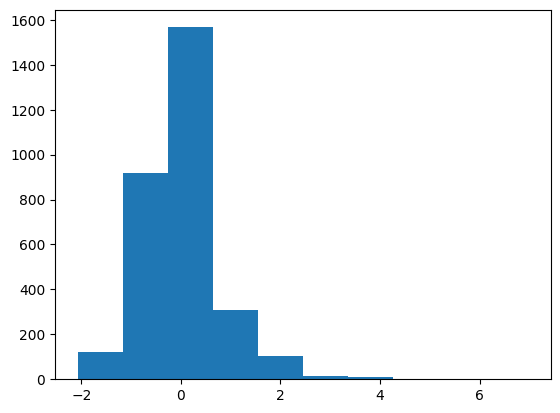

In [178]:
plt.hist([a-b for a,b in zip(yte,pred)])

In [179]:
pred=reg.predict(phDF_test.loc[testBins[regVar][3]])

In [180]:
reg.predict(phDF_test.loc[testBins[regVar][3]])

array([0.97688253, 2.10977934, 1.41461017, 1.51659696, 0.95017882,
       1.78923175, 1.67956304, 0.66722292, 0.91422114, 2.24691239,
       2.23132266, 2.23312843, 2.06520271, 0.81182847, 2.21017359,
       2.03275318, 1.25720811, 1.8264578 , 2.19518159, 1.32572831,
       1.59438663, 1.31220739, 2.18858677, 2.24693463, 2.24693807,
       2.24413636, 0.97289717, 1.78058178, 1.18240322, 2.21657977,
       1.91501134, 1.15135941, 1.43034938, 2.06495917])

In [172]:
sse

{'NN_5L': 1.0362038188719052,
 'NN_10L': 0.8782959827816543,
 'NN_50L': 2.1611199776224965,
 'NN_2L': 0.9311570419277444,
 'NN_3L': 0.9363347630304368,
 'NN_3L_logistic': 0.6211216858528908,
 'NN_2L_logistic': 0.638073386043934,
 'NN_5L_logistic': 0.601157650950131,
 'NN_10L_logistic': 0.6113046200838715,
 'NN_2L_logistic_abs': 0.638073386043934}

In [159]:
sse

{'NN_5L': 1.0362038188719052,
 'NN_10L': 0.8782959827816543,
 'NN_50L': 2.1611199776224965,
 'NN_2L': 0.9311570419277444,
 'NN_3L': 0.9363347630304368,
 'NN_3L_logistic': 0.6211216858528908}

In [128]:
reg=LinearRegression()
reg.fit(phDF_train,ytr)




LinearRegression()

In [90]:
pred=reg.predict(phDF_test)
yte=[df.loc[ind][regVar] for ind in teInd]

for k in zip(pred,yte):
    print(k)
    

(0.9024811448398327, 0.771717)
(2.171717551248257, 0.269496)
(-0.36464914244207924, 0.128796)
(1.403962594238685, 0.185432)
(1.2395652051563888, 0.646864)
(1.6243449507824084, 0.545297)
(0.7882125380638103, 0.386914)
(0.32794049058338026, 0.217427)
(0.8981554486599566, 0.385269)
(0.8463096565819728, 0.145361)
(1.1687924123470952, 0.317109)
(1.5122513938003908, 0.166841)
(0.8204323862469141, 0.181236)
(0.8530641461475101, 0.767768)
(1.0229774173712871, 0.502348)
(1.3772563197264776, 0.727122)
(0.7085579229496874, 0.009662)
(1.76967283929843, 0.596112)
(0.7401709117766517, 0.371438)
(1.0654280560920528, 0.557503)
(1.100590275367715, 0.915679)
(0.9741949860690442, 0.242702)
(0.8713462125961018, 0.598978)
(0.9075279442931719, 0.700279)
(0.8623102331912309, 0.332877)
(0.2591670092260687, 0.268446)
(0.7288999484759933, 0.252066)
(1.3710724854099612, 0.407185)
(0.8952223317683023, 0.774122)
(1.3249960146053787, 0.514161)
(0.40548290986770774, 0.658801)
(-0.05962316984915339, 0.253842)
(0.6468

In [105]:
df=pd.read_csv(r"Z:\data\diverse_metals\post-combustion-vsa-2-clean.csv",index_col=0)
regVar="mmol/g_working_capacity"#"mmol/g_working_capacity""selectivity"
ytr=[df.loc[ind][regVar] for ind in trainMOFs]

reg=DecisionTreeRegressor(random_state=42)
reg.max_depth=16
reg.fit(phDFSub.loc[trainMOFs],ytr)

DecisionTreeRegressor(max_depth=16, random_state=42)

In [106]:
roundDig=4
print(*((round(i,roundDig),round(j,roundDig)) for i,j in zip(list(reg.predict(phDFSub.loc[testMOFs])),df.loc[testMOFs][regVar])))

(1.6065, 0.5659) (4.1013, 1.5276) (0.3312, 0.5945) (0.6617, 0.3592) (1.053, 0.8074) (1.4203, 0.6479) (0.5032, 0.5556) (1.0897, 0.6882) (0.6063, 0.1367) (0.3312, 0.3453) (2.0726, 1.7692) (0.2902, 0.1684) (0.7524, 0.2399) (0.7077, 1.7558) (2.5388, 2.2813) (0.1537, 0.7407) (0.4178, 0.6184) (0.2776, 0.1766) (0.8047, 0.3501) (0.7077, 1.1615) (0.3257, 0.6012) (0.7267, 1.4392) (0.5804, 0.2396) (0.0784, 1.0763) (1.8403, 2.2893) (0.2858, 0.2685) (2.2204, 1.1096) (1.4203, 3.5321) (3.0365, 1.579) (2.0283, 1.01) (0.5765, 0.0162) (0.2776, 0.2578) (2.6265, 2.2932) (0.7077, 1.485) (0.3312, 0.2155) (0.4358, 0.3593) (1.053, 1.8278) (0.3638, 0.3284) (0.4778, 0.3616) (0.4358, 0.9075) (0.7524, 0.245) (0.5438, 0.4838) (0.255, 0.7243) (0.6826, 1.0107) (0.3706, 0.5653) (1.0035, 3.1612) (2.0726, 2.9756) (0.4358, 0.2316) (1.4445, 1.3521) (0.8075, 1.5918) (0.5765, 0.1892) (1.0897, 1.8931) (2.0571, 1.0387) (0.972, 0.515) (0.7077, 0.29) (0.7524, 0.9904) (0.3319, 0.3714) (2.0963, 0.4267) (0.5765, 0.6188) (3.5176, 

In [59]:
print(sklearn.tree.export_text(reg))

|--- feature_220 <= 29.50
|   |--- feature_118 <= 0.50
|   |   |--- feature_371 <= 1.50
|   |   |   |--- feature_202 <= 0.50
|   |   |   |   |--- feature_391 <= 15.50
|   |   |   |   |   |--- feature_205 <= 2.50
|   |   |   |   |   |   |--- feature_220 <= 14.50
|   |   |   |   |   |   |   |--- feature_226 <= 1.50
|   |   |   |   |   |   |   |   |--- feature_363 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_384 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [25.40]
|   |   |   |   |   |   |   |   |   |--- feature_384 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [205.32]
|   |   |   |   |   |   |   |   |--- feature_363 >  0.50
|   |   |   |   |   |   |   |   |   |--- feature_360 <= 1.00
|   |   |   |   |   |   |   |   |   |   |--- value: [531.08]
|   |   |   |   |   |   |   |   |   |--- feature_360 >  1.00
|   |   |   |   |   |   |   |   |   |   |--- value: [69.94]
|   |   |   |   |   |   |   |--- feature_226 >  1.50
|   |   |   |   |   |   |   |   

In [ ]:
# we need a convolutional NN over the boundary space.

In [ ]:
import tensorflow.keras as keras

class RegressionCNN:
  def __init__(self, input_shape, output_size):
    self.input_shape = input_shape
    self.output_size = output_size
    self.model = self.build_model()

  def build_model(self):
    model = keras.Sequential()

    # add convolutional layers
    model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=self.input_shape))
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.25))

    # add dense layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(self.output_size, activation='linear'))

    # compile the model
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())
    return model

  def train(self, x_train, y_train, batch_size, epochs):
    self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

  def predict(self, x):
    return self.model.predict(x)
